# Hyperparameter Tuning - CNN+LSTM

## Imports

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 8.1 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171048 sha256=851c09c57553724da0530820230ddad8a3bd215f1bae5d7ce7cea121704d11ab
  Stored in directory: /root/.cache/pip/wheels/fa/7a/e9/22dd0515e1bad255e51663ee513a2fa839c95934c5fc301090
Successfully built emoji


In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from collections import Counter
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import hyperparameters
import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the Data

In [ ]:
#Loading the Dataset
dataset = pd.read_csv('/content/drive/MyDrive/CZ4034/final_dataset.csv')
dataset.drop('Unnamed: 0', axis=1, inplace=True)

# # of rows = 5000, # of cols = 2
print(dataset.shape)

(1306, 2)


In [ ]:
#Exploring the Dataset
print(dataset['flair_labels'].value_counts())

1    653
0    653
Name: flair_labels, dtype: int64


In [ ]:
#Count all the unique words - input to fxn: column [series]
prev_list = []

for review in dataset.Review:
    string_list = review.split(' ')
    string_list += prev_list
    prev_list = string_list

counter = Counter(string_list)

#Getting the number of unique words
num_unique_words = len(counter)

#Getting the top 10 most commonly used words
most_common = counter.most_common(10)

most_common

[('skin', 1334),
 ('product', 458),
 ('like', 380),
 ('love', 330),
 ('using', 324),
 ('use', 324),
 ('face', 309),
 ('really', 275),
 ('dry', 229),
 ('im', 227)]

In [ ]:
#Splitting into trianing and validation splits
x_train, x_test, y_train, y_test = train_test_split(dataset['Review'], dataset['flair_labels'], test_size=0.2, random_state=42)
#x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

print(f"Train: {len(x_train)}")
#print(f"Val: {len(x_val)}")
print(f"Test: {len(x_test)}")
# Train - 1568 , Test - 392

Train: 1044
Test: 262


In [ ]:
#Convert from Series into Numpy Array
train_sentences = x_train.to_numpy()
train_labels = y_train.to_numpy()

#val_sentences = x_val.to_numpy()
#val_labels = y_val.to_numpy()

test_sentences = x_test.to_numpy()
test_labels = y_test.to_numpy()

In [ ]:
#Tokenization - vectorise a text corpus by converting text into a sequence of integers
#this also generates a word index
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

#writing the word index into a text file

with open("/content/drive/MyDrive/CZ4034/final_data_word_idx.txt", 'w') as f:
    f.write(json.dumps(word_index))

In [ ]:
#Converting the text into sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
#val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

#Getting the longest review
MAX_LEN = len(max(train_sequences))

#Padding the Sequences
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
#val_padded = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:
print('Train:',train_padded.shape)
#print('Val:',val_padded.shape)
print('Test:',test_padded.shape)
"""
NOTE: 
  • Train Padded Shape: (1568, 22)
  • Valid Padded Shape: (196, 22)
  • Test Padded Shape: (392, 22)
"""

Train: (1044, 40)
Test: (262, 40)


'\nNOTE: \n  • Train Padded Shape: (1568, 22)\n  • Valid Padded Shape: (196, 22)\n  • Test Padded Shape: (392, 22)\n'

In [ ]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
#val_labels = le.fit_transform(val_labels)
test_labels = le.fit_transform(test_labels)

In [ ]:
print(f"Training")
print(f"0: {list(train_labels).count(0)}")
print(f"1: {list(train_labels).count(1)}\n")

#print("Val")
#print(f"0: {list(val_labels).count(0)}")
#print(f"1: {list(val_labels).count(1)}\n")

print("Test")
print(f"0: {list(test_labels).count(0)}")
print(f"1: {list(test_labels).count(1)}\n")

Training
0: 527
1: 517

Test
0: 126
1: 136



## Loading the Model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/CZ4034/CNN_LSTM/model.hdf5')
loaded_model

In [ ]:
def build_model(hp):
  model = Sequential([
      Embedding(num_unique_words, 
                output_dim=hp.Int('num_embedding_neurons', min_value=50, max_value=200, step=50), 
                input_length=MAX_LEN, 
                trainable=True),
      Conv1D(filters=hp.Int('conv1_filter', min_value=32, max_value=128, step=16), 
           kernel_size=hp.Choice('conv1_kernel_size', values=[3,5]),
           padding='same', 
           activation='relu'),
      MaxPooling1D(pool_size=2),
      LSTM(hp.Int('num_LSTM_nodes',min_value=50, max_value=300, step=50)),
      Dense(1, activation='sigmoid')])

  model.compile(loss='binary_crossentropy', optimizer=Adam(hp.Choice('lr', values=[1e-2, 1e-3])), metrics=['accuracy'])

  return model

In [ ]:
random_search = RandomSearch(build_model, objective='val_accuracy', max_trials=10, directory='/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/final', project_name='CNN_LSTM')

In [ ]:
#Getting a full summary
random_search.search_space_summary()

Search space summary
Default search space size: 5
num_embedding_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
conv1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv1_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
num_LSTM_nodes (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 300, 'step': 50, 'sampling': 'linear'}
lr (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [ ]:
#runs the whole random search to get best hyperparamters
random_search.search(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels))

Trial 10 Complete [00h 00m 44s]
val_accuracy: 0.7633587718009949

Best val_accuracy So Far: 0.8206107020378113
Total elapsed time: 00h 06m 49s


In [ ]:
best_hyp = random_search.get_best_hyperparameters()[0]
optimized_model = random_search.hypermodel.build(best_hyp)
optimized_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 150)           568350    
                                                                 
 conv1d_4 (Conv1D)           (None, 40, 48)            36048     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 20, 48)           0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 250)               299000    
                                                                 
 dense_4 (Dense)             (None, 1)                 251       
                                                                 
Total params: 903,649
Trainable params: 903,649
Non-trainable params: 0
________________________________________________

In [ ]:
trial_02 = {"trial_id": "02", "hyperparameters": {"space": [{"class_name": "Int", "config": {"name": "num_embedding_neurons", "default": null, "conditions": [], "min_value": 50, "max_value": 200, "step": 50, "sampling": "linear"}}, {"class_name": "Int", "config": {"name": "conv1_filter", "default": null, "conditions": [], "min_value": 32, "max_value": 128, "step": 16, "sampling": "linear"}}, {"class_name": "Choice", "config": {"name": "conv1_kernel_size", "default": 3, "conditions": [], "values": [3, 5], "ordered": true}}, {"class_name": "Int", "config": {"name": "num_LSTM_nodes", "default": null, "conditions": [], "min_value": 50, "max_value": 300, "step": 50, "sampling": "linear"}}, {"class_name": "Choice", "config": {"name": "lr", "default": 0.01, "conditions": [], "values": [0.01, 0.001], "ordered": true}}], "values": {"num_embedding_neurons": 150, "conv1_filter": 48, "conv1_kernel_size": 5, "num_LSTM_nodes": 250, "lr": 0.001}}, "metrics": {"metrics": {"loss": {"direction": "min", "observations": [{"value": [0.1947953850030899], "step": 2}]}, "accuracy": {"direction": "max", "observations": [{"value": [0.9348658919334412], "step": 2}]}, "val_loss": {"direction": "min", "observations": [{"value": [0.5206506252288818], "step": 2}]}, "val_accuracy": {"direction": "max", "observations": [{"value": [0.8206107020378113], "step": 2}]}}}, "score": 0.8206107020378113, "best_step": 2, "status": "COMPLETED", "message": null}

For the Final Dataset - Trial02:

1. Number of Neurons in the Embedding Layer - 150
2. Number of Filters in the 1st Conv Layer - 48
3. Kernel Size in the 1st Conv Layer - 5
4. Number of Neurons in the LSTM Layer - 250
5. Learning Rate - 0.001



## Retraining Optimized Model on the Training Dataset

In [ ]:
#Creating base model
model = Sequential()

model.add(Embedding(num_unique_words, output_dim=150, input_length=MAX_LEN, trainable=True))
#adding the CONV layer
model.add(Conv1D(filters=48, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(250))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 150)           568350    
                                                                 
 conv1d (Conv1D)             (None, 40, 48)            36048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 48)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 250)               299000    
                                                                 
 dense (Dense)               (None, 1)                 251       
                                                                 
Total params: 903,649
Trainable params: 903,649
Non-trainable params: 0
__________________________________________________

In [ ]:
import time
t0 = time.time()
hist = model.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))
print(f"Training TIme:{time.time()-t0}")

In [ ]:
hist = model.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))

Epoch 1/5
33/33 [==============================] - 10s 201ms/step - loss: 0.6899 - accuracy: 0.5431 - val_loss: 0.6843 - val_accuracy: 0.5382
Epoch 2/5
33/33 [==============================] - 7s 212ms/step - loss: 0.5540 - accuracy: 0.7050 - val_loss: 0.4488 - val_accuracy: 0.8053
Epoch 3/5
33/33 [==============================] - 4s 113ms/step - loss: 0.2515 - accuracy: 0.9052 - val_loss: 0.5063 - val_accuracy: 0.8053
Epoch 4/5
33/33 [==============================] - 3s 92ms/step - loss: 0.1046 - accuracy: 0.9684 - val_loss: 0.6275 - val_accuracy: 0.7977
Epoch 5/5
33/33 [==============================] - 3s 85ms/step - loss: 0.0300 - accuracy: 0.9895 - val_loss: 1.0805 - val_accuracy: 0.8015


In [ ]:
history_opt = optimized_model.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))

Epoch 1/5
33/33 [==============================] - 9s 178ms/step - loss: 0.6912 - accuracy: 0.5268 - val_loss: 0.6877 - val_accuracy: 0.5802
Epoch 2/5
33/33 [==============================] - 4s 114ms/step - loss: 0.6021 - accuracy: 0.6705 - val_loss: 0.5516 - val_accuracy: 0.7481
Epoch 3/5
33/33 [==============================] - 5s 137ms/step - loss: 0.3128 - accuracy: 0.8994 - val_loss: 0.5504 - val_accuracy: 0.8053
Epoch 4/5
33/33 [==============================] - 3s 84ms/step - loss: 0.1567 - accuracy: 0.9559 - val_loss: 0.5116 - val_accuracy: 0.8092
Epoch 5/5
33/33 [==============================] - 2s 60ms/step - loss: 0.0799 - accuracy: 0.9780 - val_loss: 0.6033 - val_accuracy: 0.7863


In [ ]:
with open('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/final/optimized_hist_cnn_lstm.txt', 'w') as convert_file:
     convert_file.write(json.dumps(history_opt.history))

In [ ]:
random_search.get_best_hyperparameters

<bound method BaseTuner.get_best_hyperparameters of <keras_tuner.tuners.randomsearch.RandomSearch object at 0x7f80e4491430>>

## Plotting Loss and Accuracy Curves

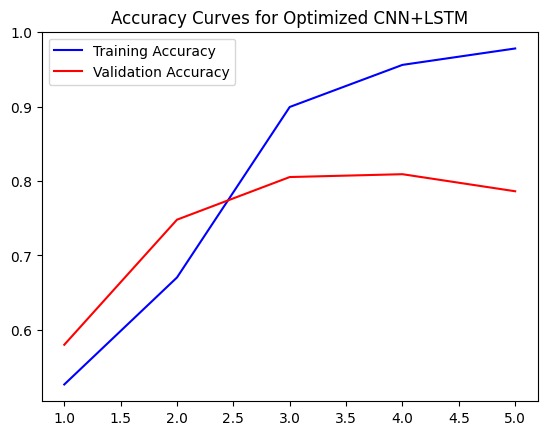

<Figure size 640x480 with 0 Axes>

In [ ]:
#PLOTTING THE CURVES
epochs = range(1,6)

#Plotting the Accuracy Curves
train_accuracy = history_opt.history['accuracy']
val_accuracy = history_opt.history['val_accuracy']

plt.plot(epochs,train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs,val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy Curves for Optimized CNN+LSTM')
plt.legend()
plt.figure()
plt.savefig('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/final/cnnlstm_opt_try1_Accuracy.jpg')

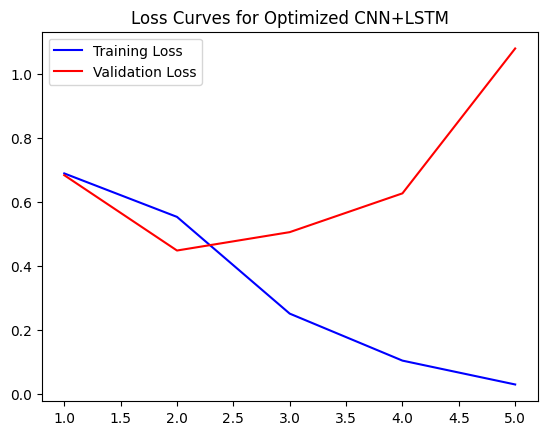

In [ ]:
#Plotting the Loss Curves
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(epochs,train_loss, 'b', label='Training Loss')
plt.plot(epochs,val_loss, 'r', label='Validation Loss')
plt.title('Loss Curves for Optimized CNN+LSTM')
plt.legend()
plt.show()
#plt.savefig('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/final/cnnlstm_opt_try1_Loss.jpg')

## Evaluating the Optimized model

In [ ]:
prev_model_scores = loaded_model.evaluate(test_padded, test_labels, verbose=1,batch_size = 64)
print("Accuracy: %.2f%%" % (prev_model_scores[1]*100))

5/5 [==============================] - 0s 4ms/step - loss: 0.7752 - accuracy: 0.7786
Accuracy: 77.86%


In [ ]:
optimized_model_scores = optimized_model.evaluate(test_padded, test_labels, verbose=1, batch_size=64)
print("Accuracy: %.2f%%" % (optimized_model_scores[1]*100))

5/5 [==============================] - 0s 7ms/step - loss: 1.5456 - accuracy: 0.7519
Accuracy: 75.19%


In [ ]:
model_scores = model.evaluate(test_padded, test_labels, verbose=1, batch_size=64)
print("Accuracy: %.2f%%" % (model_scores[1]*100))

5/5 [==============================] - 0s 5ms/step - loss: 1.0805 - accuracy: 0.8015
Accuracy: 80.15%


In [ ]:
model.save('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/final/final_optimized_model.hdf5')

### Getting Components of the Confusion Matrix

#### Previous Model

In [ ]:
prev_predictions = loaded_model.predict(test_padded)
prev_predictions = [1 if p > 0.5 else 0 for p in prev_predictions]

9/9 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

prev_conf_matrix = confusion_matrix(test_labels, prev_predictions)
p_tn, p_fp, p_fn, p_tp = prev_conf_matrix.ravel()

print("Previous Model:")

print(f"True Positives: {p_tp}")
print(f"True Negatives: {p_tn}")
print(f"False Positives: {p_fp}")
print(f"False Negatives: {p_fn}")

Previous Model:
True Positives: 111
True Negatives: 93
False Positives: 33
False Negatives: 25


#### Optimized Model

In [ ]:
#FOR TIME
t1 = time.time()
model_scores = model.evaluate(test_padded, test_labels, verbose=1, batch_size=64)
print("Accuracy: %.2f%%" % (model_scores[1]*100), f"INference TIme: {time.time()-t1}")

In [ ]:
model = load_model('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/final/final_optimized_model.hdf5')
model

In [ ]:
model_scores = model.evaluate(test_padded, test_labels, verbose=1, batch_size=64)
print("Accuracy: %.2f%%" % (model_scores[1]*100))

5/5 [==============================] - 10s 12ms/step - loss: 1.0805 - accuracy: 0.8015
Accuracy: 80.15%


In [ ]:
optimized_model = tf.keras.models.load_model('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/final/final_optimized_model.hdf5')

In [ ]:
optimized_predictions = optimized_model.predict(test_padded)
optimized_predictions = [1 if p > 0.5 else 0 for p in optimized_predictions]

9/9 [==============================] - 0s 3ms/step


In [ ]:
model_predictions = model.predict(test_padded)
model_predictions = [1 if p > 0.5 else 0 for p in model_predictions]

9/9 [==============================] - 1s 4ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(test_labels, model_predictions)
o_tn, o_fp, o_fn, o_tp = conf_matrix.ravel()

print("Optimized Model:")

print(f"True Positives: {o_tp}")
print(f"True Negatives: {o_tn}")
print(f"False Positives: {o_fp}")
print(f"False Negatives: {o_fn}")

Optimized Model:
True Positives: 113
True Negatives: 97
False Positives: 29
False Negatives: 23


In [ ]:
print(classification_report(test_labels, model_predictions))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       126
           1       0.80      0.83      0.81       136

    accuracy                           0.80       262
   macro avg       0.80      0.80      0.80       262
weighted avg       0.80      0.80      0.80       262



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

opt_conf_matrix = confusion_matrix(test_labels, optimized_predictions)
o_tn, o_fp, o_fn, o_tp = opt_conf_matrix.ravel()

print("Optimized Model:")

print(f"True Positives: {o_tp}")
print(f"True Negatives: {o_tn}")
print(f"False Positives: {o_fp}")
print(f"False Negatives: {o_fn}")

## Testing on Individual Texts

In [ ]:
#Function to process the test sample in the same way as the data processing of training
import numpy as np
from cleantext import clean

#takes in a string(text) and returns a padded sequence 
def process_eval_sample(text):
  text = clean(text, no_emoji=True, no_punct=True, lower=True)
  text = text.split(" ")
  sentence = np.array(text)
  sequence = tokenizer.texts_to_sequences(sentence)
  padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')

  return padded_sequence

#takes in a padded sequence and returns an integer (0 or 1) for the label
def pred_prev_model(padded_seq):
  predictions = loaded_model.predict(padded_seq)[0]
  print(f"Predicted Value: {predictions}")
  pred_values = [1 if p>=0.5 else 0 for p in predictions]
  pred_label = max(pred_values)

  return pred_label

def pred_optimized_model(padded_seq):
  predictions = optimized_model.predict(padded_seq)[0]
  print(f"Predicted Value: {predictions}")
  pred_values = [1 if p>=0.5 else 0 for p in predictions]
  pred_label = max(pred_values)

  return pred_label

### Previous Model

In [ ]:
eval1_text = "cured my acne scars. Worked miraculously"
gt1_label = '1'

eval1 = process_eval_sample(eval1_text)
eval1_label = pred_prev_model(eval1)

print(f"Eval Sample 1: {eval1_text}")
print(f"Ground Truth Label: {gt1_label}")
print(f"Predicted Label: {eval1_label}")

1/1 [==============================] - 0s 22ms/step
Predicted Value: [0.9864878]
Eval Sample 1: cured my acne scars. Worked miraculously
Ground Truth Label: 1
Predicted Label: 1


In [ ]:
eval2_text = "I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again."
gt2_label = '0'

eval2 = process_eval_sample(eval2_text)
eval2_label = pred_prev_model(eval2)

print(f"Predictions: {loaded_model.predict(eval2)[0]}")
print(f"Eval Sample 2: {eval2_text}")
print(f"Ground Truth Label: {gt2_label}")
print(f"Predicted Label: {eval2_label}")

2/2 [==============================] - 0s 9ms/step
Predicted Value: [0.9864878]
2/2 [==============================] - 0s 10ms/step
Predictions: [0.9864878]
Eval Sample 2: I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again.
Ground Truth Label: 0
Predicted Label: 1


In [ ]:
eval3_text = "best product ever!"
gt3_label = '1'

eval3 = process_eval_sample(eval3_text)
eval3_label = pred_prev_model(eval3)

print(f"Eval Sample 3: {eval3_text}")
print(f"Ground Truth Label: {gt3_label}")
print(f"Predicted Label: {eval3_label}")

1/1 [==============================] - 0s 21ms/step
Predicted Value: [0.98547864]
Eval Sample 3: best product ever!
Ground Truth Label: 1
Predicted Label: 1


### Optimized Model

In [ ]:
eval1_text = "cured my acne scars. Worked miraculously"
gt1_label = '1'

eval1 = process_eval_sample(eval1_text)
eval1_label = pred_optimized_model(eval1)

print(f"Eval Sample 1: {eval1_text}")
print(f"Ground Truth Label: {gt1_label}")
print(f"Predicted Label: {eval1_label}")

1/1 [==============================] - 0s 23ms/step
Predicted Value: [0.9956344]
Eval Sample 1: cured my acne scars. Worked miraculously
Ground Truth Label: 1
Predicted Label: 1


In [ ]:
eval2_text = "I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again."
gt2_label = '0'

eval2 = process_eval_sample(eval2_text)
eval2_label = pred_optimized_model(eval2)

print(f"Predictions: {loaded_model.predict(eval2)[0]}")
print(f"Eval Sample 2: {eval2_text}")
print(f"Ground Truth Label: {gt2_label}")
print(f"Predicted Label: {eval2_label}")

2/2 [==============================] - 0s 6ms/step
Predicted Value: [0.9956344]
2/2 [==============================] - 0s 6ms/step
Predictions: [0.9864878]
Eval Sample 2: I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again.
Ground Truth Label: 0
Predicted Label: 1


In [ ]:
eval3_text = "best product ever!"
gt3_label = '1'

eval3 = process_eval_sample(eval3_text)
eval3_label = pred_optimized_model(eval3)

print(f"Eval Sample 3: {eval3_text}")
print(f"Ground Truth Label: {gt3_label}")
print(f"Predicted Label: {eval3_label}")

1/1 [==============================] - 0s 22ms/step
Predicted Value: [0.94840926]
Eval Sample 3: best product ever!
Ground Truth Label: 1
Predicted Label: 1
